In [1]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
import torch

In [3]:
# Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# GPU
if exists('/dev/nvidia0'):
        device = torch.device('CUDA') 
        accelerator = cuda_output[0]
else:
        device = torch.device('cpu') 
        accelerator= 'cpu' 

# Load and clean data

In [5]:
# Download data
legitimate_URLs = np.load("small_data/legitimate_URLs.npy")
# legitimate_URLs = np.concatenate((legitimate_URLs,np.load("/content/gdrive/My Drive/legitimate_URLs2.npy")))
phishing_URLs = np.load("small_data/phishing_URLs.npy")
phishing_URLs = np.concatenate((phishing_URLs,np.load("small_data/phishing_URLs2.npy")))

# randomly permute URLs
np.random.seed(0)
legitimate_URLs = list(legitimate_URLs[np.random.permutation(len(legitimate_URLs))])
phishing_URLs = list(phishing_URLs[np.random.permutation(len(phishing_URLs))])

# clean URLs
legitimate_URLs = [l.split('http://')[-1].split('www.')[-1].split('https://')[-1] for l in legitimate_URLs]
phishing_URLs = [p.split('http://')[-1].split('www.')[-1].split('https://')[-1] for p in phishing_URLs]
phishing_URLs = list(set(phishing_URLs) - set(legitimate_URLs))

In [6]:
len(legitimate_URLs), len(phishing_URLs)

# Phishing > Legit, Dataset troppo piccolo

(14999, 5339)

In [7]:
phishing_URLs.remove('')

In [8]:
# map to numbers
letters = ''.join(legitimate_URLs+phishing_URLs) #String unica di URL senza spazi
from collections import Counter
c = Counter(letters) # Dizionario con occorrenze delle lettere
d = {}
for i, (l, _) in enumerate(c.most_common(128)):
    d[l] = i + 1 # Dizionario ordinato per numero di occorrenze

In [18]:
# training set: all keys plus non-keys
# testing set: remaining non-keys 
training_list = legitimate_URLs[:int(len(legitimate_URLs)/2)]+phishing_URLs
testing_list = legitimate_URLs[int(len(legitimate_URLs)/2):]
    
# cut off at 150 chars
char_cutoff = 150

# Matrice con entry i vari URL del training set portati a 150 char con eventuale padding/troncatura.
# Gli URL vengono rappresentati sostiuendo ad ogni lettera l'int rappresentante la posizione nelle occorrenze
X_train = torch.tensor([[d.get(l,0) for l in url[:min([len(url),char_cutoff])]]+[0 for l in range(char_cutoff-len(url))] 
                        for url in training_list])
y_train = torch.tensor([0]*int(len(legitimate_URLs)/2)+[1]*int(len(phishing_URLs)))

X_test = torch.tensor([[d.get(l,0) for l in url[:min([len(url),char_cutoff])]]+[0 for l in range(char_cutoff-len(url))] 
                        for url in testing_list])
y_test = torch.tensor([0]*(len(testing_list)))

X_train.size()

torch.Size([12837, 150])

In [19]:
# Batch data
def make_batch_train(X_t, y_t, B):
  sample = torch.randint(0, X_t.shape[0], [B]).long()
  batch_X0 = torch.stack([X_t[s] for s in sample])
  batch_X = batch_X0.to(device)
  batch_y0 = torch.stack([y_t[s]*torch.ones(len(X_t[s])).long() for s in sample]).to(device)     #
  batch_y = batch_y0.to(device)
  return batch_X, batch_y
  
def make_batch_test(X_t, y_t, B):
  sample = torch.randint(0, X_t.shape[0], [B]).long()
  batch_X0 = torch.stack([X_t[s] for s in sample])
  batch_X = batch_X0.to(device)
  batch_y0 = torch.stack([y_t[s] for s in sample]).to(device)
  batch_y = batch_y0.to(device)
  return batch_X, batch_y


In [20]:
class RNN(nn.Module):
    def __init__(self, input_size=150, output_size=2, emb_size=128, h_size=128, layers=1, dropout=0.3):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(input_size, emb_size)
        self.rnn = nn.GRU(emb_size, h_size, num_layers=layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(h_size, output_size)
        
    def forward(self, x, h=None):
        x = self.embedding(x)
        x, h = self.rnn(x, h)
        x = self.linear(x)
        return x, h

In [21]:
def val(model, X_t, y_t):
    model.eval()
    with torch.no_grad():
        total = 0
        total_right = 0
        total_loss = 0
        for batch in range(50):
            x,y = make_batch_test(X_t, y_t, 256)
            y_hat, _ = model(x)
            #optimizer.zero_grad()
            preds = y_hat.max(dim=2)[1][:,149]
            preds_eq = preds.eq(y)
            total_right += preds_eq.sum().item()
            total += preds_eq.numel()
            loss = criterion(y_hat[:,149].view(-1,2), y.view(-1).long()).detach().item()
            total_loss += loss
    return total_right / total, total_loss / 50

In [22]:
def train(model):
    model.train()
    total_loss = 0
    for batch in range(50):
        x, y = make_batch_train(X_train, y_train, 256)
        y_hat, _ = model(x)
        optimizer.zero_grad()
        y_hat = y_hat.view(-1,2)
        y = y.view(-1).long()
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
    total_loss += loss.item()
    return total_loss / 50

In [23]:
emb_size=5
h_sizes = [16,8,4]
layers = 1
criterion = nn.CrossEntropyLoss()
#loc = "/content/gdrive/My Drive/College/current classes/CS 222 fall 2018/CS222 Project/simulations/"
loc = "trained_NN/simulations/"
#plot_loc = "/content/gdrive/My Drive/College/current classes/CS 222 fall 2018/CS222 Project/plots/"
plot_loc = "/content/gdrive/My Drive/trained_NN/plots/"

# Train (don't need to run this)

In [12]:
models = {}
for i in range(3):
  h_size = h_sizes[i]
  # Create model, loss function, optimizer
  models[i] = RNN(emb_size=emb_size, h_size=h_size, layers=layers).to(device)
  optimizer = torch.optim.Adamax(models[i].parameters())

  # Train and validate
  start = time.time()
  for epoch in range(30):
      train_loss = train(models[i])
      val_acc, val_loss = val(models[i],X_train,y_train)
      if(epoch%10 == 0):
        print('[E{:4d}] Loss: {:.4f} | Acc: {:.4f}'.format(epoch, val_loss, val_acc))
  end = time.time()
  print(end-start)
  torch.save(models[i].state_dict(), loc+"RNN_emb"+str(emb_size)+"_hid"+str(h_size))  

NameError: name 'RNN' is not defined

# Load trained RNNs and evaluate (change paths)

In [24]:
# sizes of RNN models
models = {}
model_sizes = {}
for i,h_size in enumerate(h_sizes):
  print("hidden size", h_size)
  model_sizes[i] = os.path.getsize(loc+"RNN_emb"+str(emb_size)+"_hid"+str(h_size))
  print("model size (bytes)", model_sizes[i])
  models[i] = RNN(emb_size=emb_size, h_size=h_size, layers=layers).to(device)
  models[i].load_state_dict(torch.load(loc+"RNN_emb"+str(emb_size)+"_hid"+str(h_size)))
  models[i].eval()
  print(val(models[i], X_test,y_test))
  
  avg_time = 0
  for t in range(100):
    x,y = make_batch_test(X_test, y_test,1)
    start = time.time()
    models[i](x)
    total = time.time()-start
    avg_time += total
  avg_time /= 100
  print("time to evaluate", avg_time)
  print("="*30)

hidden size 16
model size (bytes) 10222
(0.97703125, 0.09036014415323734)
time to evaluate 0.009250607490539551
hidden size 8
model size (bytes) 7086
(0.990546875, 0.034956679292954505)
time to evaluate 0.008949613571166993
hidden size 4
model size (bytes) 6062
(1.0, 0.004214989338070154)
time to evaluate 0.009851527214050294


# Bloom Filter Class

In [25]:
import mmh3
import math
import torch
from bitarray import bitarray 

class BloomFilter(object): 
  
    def __init__(self, items_count,fp_prob): 
        ''' 
        items_count : int 
            Number of items expected to be stored in bloom filter 
        fp_prob : float 
            False Positive probability in decimal 
        '''
        # False posible probability in decimal 
        self.fp_prob = fp_prob 
  
        # Size of bit array to use 
        self.size = self.get_size(items_count,fp_prob) 
  
        # number of hash functions to use 
        self.hash_count = self.get_hash_count(self.size,items_count) 
  
        # Bit array of given size 
        self.bit_array = bitarray(self.size) 
  
        # initialize all bits as 0 
        self.bit_array.setall(0) 
  
    def add(self, item): 
        ''' 
        Add an item in the filter 
        '''
        digests = [] 
        for i in range(self.hash_count): 
            # i works as seed to mmh3.hash() function 
            digest = mmh3.hash(item,i) % self.size 
            digests.append(digest) 
  
            # set the bit True in bit_array 
            self.bit_array[digest] = True
  
    def check(self, item): 
        ''' 
        Check for existence of an item in filter 
        '''
        for i in range(self.hash_count): 
            digest = mmh3.hash(item,i) % self.size 
            if self.bit_array[digest] == False: 
  
                # if any of bit is False then,its not present 
                # in filter 
                # else there is probability that it exist 
                return False
        return True
  
    @classmethod
    def get_size(self,n,p): 
        ''' 
        Return the size of bit array(m) to used using 
        following formula 
        m = -(n * lg(p)) / (lg(2)^2) 
        n : int 
            number of items expected to be stored in filter 
        p : float 
            False Positive probability in decimal 
        '''
        m = -(n * math.log(p))/(math.log(2)**2) 
        return int(m) 
  
    @classmethod
    def get_hash_count(self, m, n): 
        ''' 
        Return the hash function(k) to be used using 
        following formula 
        k = (m/n) * lg(2) 
  
        m : int 
            size of bit array 
        n : int 
            number of items expected to be stored in filter 
        '''

        k = (m/n) * math.log(2) 
        return int(k)

# BF

In [26]:
def run_BF(FPR):
  # Crea BF su un set di Key pari al numero di phishing e con target FPR
  BF = BloomFilter(len(phishing_URLs), FPR)
  for url in phishing_URLs:
    BF.add(url)
  
  
  fps = 0
  total = 0
  total_time = 0
  # Testa il filtro di bloom su l'insieme dei legit per calcolare il tasso di FPR
  for url in testing_list:
    total += 1
    start = time.time()
    result = BF.check(url)
    end = time.time()
    total_time += (end-start)
    # Se elemento presente allora falso positivo
    if result == True:
      fps += 1
  
  avg_fp = fps/total

  # returns empirical FPR, BF size in bytes, and access time per element
  return avg_fp, BF.size/8, (total_time)/len(testing_list)

In [74]:
FPR, BF_size, t = run_BF(0.02)
print("FPR", FPR, "size", BF_size, "time", t)
BF = {"FPR": FPR, "size": BF_size, "time": t}
np.save(loc+"BF", BF)

FPR 0.020933333333333335 size 5428.875 time 1.200262705485026e-06


In [27]:
BF_sizes = {}
# Aggiungo alcuni fpr
fprs = [0.001,0.005,0.01,0.02]
# Stampa grandezza del filtro in relazione al target fpr
for fpr in fprs:
  BF = BloomFilter(len(phishing_URLs), fpr)
  BF_sizes[fpr] = BF.size / 8
  
print(BF_sizes)

{0.001: 9593.375, 0.005: 7358.25, 0.01: 6395.625, 0.02: 5432.875}


# Classifier

In [28]:
# Esegue modello in input precedentemente addestrato suddividendo i risultati in due liste 
# probs1 contiene risultati per le entry phishing
# probs0 contiene risultati per le entru legit
def get_classifier_probs(model):
    probs1 = []
    probs0 = []
    # Divisione in batch da 100
    for i in range(int(len(y_train)/100)+1):
        x0 = torch.stack([X_train[s] for s in range(100*i, min(100*(i+1), len(y_train)))])
        x = x0.to(device)
        y0 = torch.stack([y_train[s] for s in range(100*i, min(100*(i+1), len(y_train)))])
        y = y0.to(device)  
        y_hat, _ = model(x)
        ps = torch.sigmoid(y_hat[:,:,1])[:,149]
        # Squeeze causa errori con conversione in lista se fatto con tensor di dimensione 1
        # Aggiunto if else
        if(len(ps[y==1]) != 1):
            probs1 += list(ps[y==1].squeeze().detach().cpu().numpy()) 
        else:
            probs1 += list(ps[y==1].detach().cpu().numpy()) 
        if(len(ps[y==0]) != 1):
            probs0 += list(ps[y==0].squeeze().detach().cpu().numpy())
        else:
            probs0 += list(ps[y==0].detach().cpu().numpy())
    return probs1, probs0

In [29]:
# Grafici precedentemente commentati, non molto significativi?
probs = {}
urls = {}
probs[0] = get_classifier_probs(models[0])
probs[1] = get_classifier_probs(models[1])
probs[2] = get_classifier_probs(models[2])

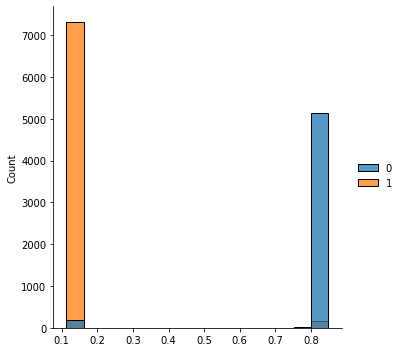

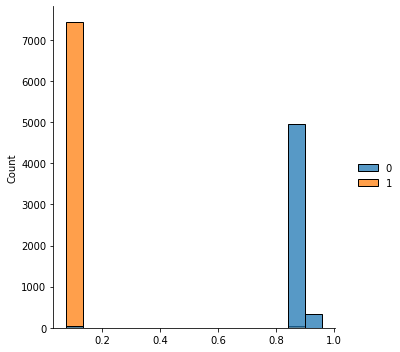

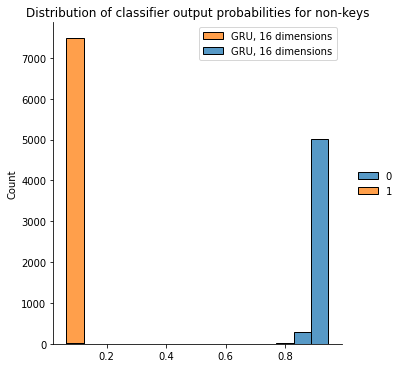

In [30]:
sns.displot(probs[0], label = "GRU, 128 dimensions")
sns.displot(probs[1], label = "GRU, 32 dimensions")
sns.displot(probs[2], label = "GRU, 16 dimensions")
plt.title("Distribution of classifier output probabilities for non-keys")
plt.legend()
plt.show()

In [31]:
def determine_tau(FPR_tau, prob_list):
  return np.percentile(np.array(prob_list),100*(1.-FPR_tau))

# LBF

In [32]:
# Costruisce classificatore per LBF e ritorna relativo numero di falsi negativi e tau ottimale
def build_LBF_classifier(model,FPR_tau):
  probs1, probs0 = get_classifier_probs(model)
  tau = determine_tau(FPR_tau,probs0)
  false_negs = []
  for i,url in enumerate(phishing_URLs):
    if(probs1[i] < tau):
      false_negs += [url]
  return false_negs, tau

In [33]:
def build_LBF_backup(false_negs, FPR, FPR_tau):
  num_false_negs = len(false_negs)
  FPR_B = (FPR-FPR_tau)/(1-FPR_tau)
  if(FPR_B <= 0):
    return "error"
  LBF_backup = BloomFilter(num_false_negs, FPR_B)
  for url in false_negs:
    LBF_backup.add(url)
  return LBF_backup

In [34]:
def test_LBF(model, LBF_backup, tau):
  # test on testing data
  fps = 0
  total = 0
  total_time = 0
  for i in range(int(len(y_test)/100)+1):
    # Aggiunto if per evitare eccezioni da stack se la lista é vuota
    if(len([X_test[s] for s in range(100*i, min(100*(i+1), len(y_test)))]) > 0):
        x0 = torch.stack([X_test[s] for s in range(100*i, min(100*(i+1), len(y_test)))])
        x = x0.to(device)
        y0 = torch.stack([y_test[s] for s in range(100*i, min(100*(i+1), len(y_test)))])
        y = y0.to(device)  
        total += len(y)

        start = time.time()
        y_hat, _ = model(x)
        ps = torch.sigmoid(y_hat[:,:,1])[:,149].squeeze().detach().cpu().numpy()
        for ix, p in enumerate(ps):
          if(p > tau):
            result = True        
          else:
            result = LBF_backup.check(testing_list[100*i+ix])
          if(result):
            fps += 1
        end = time.time()
        total_time += (end-start)

  avg_fp = fps/total
  
  # returns empirical FPR, BF size, and avg access time
  return avg_fp, LBF_backup.size / 8, (total_time)/len(y_test)

# SBF.py equivalent

In [36]:
def build_SLBF_initial(false_negs, FPR, FPR_tau):
  num_false_negs = len(false_negs)
  FPR_B0 = FPR/FPR_tau*(1.-num_false_negs/len(phishing_URLs))
  if(FPR_B0 <= 0 or FPR_B0 >= 1):
    return "error"
  SLBF_initial = BloomFilter(len(phishing_URLs), FPR_B0)
  for url in phishing_URLs:
    SLBF_initial.add(url)
  return SLBF_initial

In [37]:
def build_SLBF_backup(false_negs, FPR_tau):
  num_false_negs = len(false_negs)
  FPR_B = FPR_tau/((1-FPR_tau)*(len(phishing_URLs)/num_false_negs - 1))
  if(FPR_B <= 0):
    return "error"
  SLBF_backup = BloomFilter(num_false_negs, FPR_B)
  for url in false_negs:
    SLBF_backup.add(url)
  return SLBF_backup

In [38]:
def test_SLBF(SLBF_initial, model, SLBF_backup, tau):
  # test on testing data
  fps = 0
  total = 0
  total_time = 0
  for i in range(int(len(y_test)/100)+1):
    x0 = torch.stack([X_test[s] for s in range(100*i, min(100*(i+1), len(y_test)))])
    x = x0.to(device)
    y0 = torch.stack([y_test[s] for s in range(100*i, min(100*(i+1), len(y_test)))])
    y = y0.to(device)  
    total += len(y)
    
    start = time.time()
    y_hat, _ = model(x)
    ps = torch.sigmoid(y_hat[:,:,1])[:,149].squeeze().detach().cpu().numpy()
    for ix, p in enumerate(ps):
      result = SLBF_initial.check(testing_list[100*i+ix])
      if(result):
        if(p>tau):
          result = True
        else:
          result = SLBF_backup.check(testing_list[100*i+ix])
      if(result):
        fps += 1
    end = time.time()
    total_time += (end-start)

  avg_fp = fps/total
  
  # returns empirical FPR, BF size, and avg access time
  return avg_fp, (SLBF_initial.size+SLBF_backup.size) / 8, (total_time)/len(y_test)

# $\tau$ analysis for LBF

In [39]:
fprs = [0.001,0.005,0.01,0.02]
fpr_ratios = [0.1*i for i in range(1,11)]
false_negs = {}
taus = {}

# Per ognuno dei modelli salvo numero di falsi negativi del classificatore e tau ottimale nelle relative strutture sulla
# base del fprs e fpr_ratio target.
for i in range(3):
  false_negs[i] = {}
  taus[i] = {}
  for fpr in fprs:
    for fpr_ratio in fpr_ratios:
      false_negs[i][(fpr,fpr_ratio)], taus[i][(fpr,fpr_ratio)] = build_LBF_classifier(models[i], fpr*fpr_ratio)
      # Cambiata print
      print("Modello %d:  FPR: %.3f, FPR_ratio: %.2f, false_negs: %.20f, taus :%.10f" % (i, fpr, fpr_ratio, len(false_negs[i][(fpr,fpr_ratio)])/len(phishing_URLs), taus[i][(fpr,fpr_ratio)]))
      # print(len(false_negs[i][(fpr,fpr_ratio)])/len(phishing_URLs), taus[i][(fpr,fpr_ratio)])

Modello 0:  FPR: 0.001, FPR_ratio: 0.10, false_negs: 0.56987635818658677334, taus :0.8086026880
Modello 0:  FPR: 0.001, FPR_ratio: 0.20, false_negs: 0.51217684526039719550, taus :0.8084145082
Modello 0:  FPR: 0.001, FPR_ratio: 0.30, false_negs: 0.39040839265642562905, taus :0.8080619719
Modello 0:  FPR: 0.001, FPR_ratio: 0.40, false_negs: 0.20026227051330086626, taus :0.8074106371
Modello 0:  FPR: 0.001, FPR_ratio: 0.50, false_negs: 0.19876358186586737253, taus :0.8073999866
Modello 0:  FPR: 0.001, FPR_ratio: 0.60, false_negs: 0.18939677781940802981, taus :0.8073579111
Modello 0:  FPR: 0.001, FPR_ratio: 0.70, false_negs: 0.18040464593480703970, taus :0.8073009968
Modello 0:  FPR: 0.001, FPR_ratio: 0.80, false_negs: 0.17159985013113526753, taus :0.8072467412
Modello 0:  FPR: 0.001, FPR_ratio: 0.90, false_negs: 0.15492693892843761860, taus :0.8071389256
Modello 0:  FPR: 0.001, FPR_ratio: 1.00, false_negs: 0.14986886474334956687, taus :0.8070972185
Modello 0:  FPR: 0.005, FPR_ratio: 0.10,

In [43]:
# Salva risultati della cella precedente, ma poi li usa?
np.save(loc+"false_negs", false_negs)
np.save(loc+"taus", taus)

In [44]:
LBF_backups = {}

# Per ognuno dei modelli salvo il filtro di backup costruito sulla base del fpr e fpr_ratio target
for i in range(3):
  LBF_backups[i] = {}
  for fpr in fprs:
    for fpr_ratio in fpr_ratios:
      try:
        LBF_backups[i][(fpr,fpr_ratio)] = build_LBF_backup(false_negs[i][(fpr,fpr_ratio)], fpr, fpr*fpr_ratio)
        if(LBF_backups[i][(fpr,fpr_ratio)] =='error'):
          continue
        fpr0, BF_size, t = test_LBF(models[i], LBF_backups[i][(fpr,fpr_ratio)], taus[i][(fpr,fpr_ratio)])
        print(fpr, fpr0, BF_size, t)
        LBF = {"FPR": fpr0, "size": BF_size+model_sizes[i], "time": t}
        np.save(loc+"LBF_hid"+str(h_sizes[i])+"_FPR"+str(fpr)+"_ratio"+str(fpr_ratio), LBF)
      except:
        # Se il numero di falsi negativi é 0 sollevo eccezione e non salvo
        # Non controllata inizialmente probabilbente perché é stata esclusa la possibilitá di avere fn = 0 con dataset grandi
        print("Numero falsi negativi = 0")

0.001 0.0009333333333333333 5550.375 0.0002061708132425944
0.001 0.0006666666666666666 5072.0 0.00020079387029012043
0.001 0.0006666666666666666 3938.5 0.00022829259236653647
0.001 0.0012 2063.125 0.0002171963691711426
0.001 0.0008 2098.0 0.00020554653803507488
0.001 0.0009333333333333333 2057.75 0.00021445242563883463
0.001 0.0006666666666666666 2032.125 0.00020518210728963216
0.001 0.0008 2029.5 0.00020873193740844726
0.001 0.0009333333333333333 1981.5 0.00021084973017374676
0.005 0.0056 1491.5 0.00020437501271565754
0.005 0.0061333333333333335 1149.0 0.00021149152119954428
0.005 0.0056 1078.125 0.00021967493693033854
0.005 0.0037333333333333333 1019.75 0.00020902322133382163
0.005 0.004933333333333333 920.75 0.0002112778345743815
0.005 0.0052 903.375 0.0002487032890319824
0.005 0.005066666666666666 857.125 0.00022767035166422527
0.005 0.0048 896.25 0.0001946438471476237
0.005 0.0044 938.75 0.00022002484003702798
0.01 0.0088 980.125 0.00019912338256835937
0.01 0.012933333333333333 84

In [46]:
fnrs = {}
# Per ognuno dei modelli costruisco un dataframe in cui salvo il rate di falsi negativi per ogni fpr e fprs_ratio
for i in range(3):
  fnrs[i] = pd.DataFrame(index=fpr_ratios, columns=fprs)
  for fpr in fprs:
    for fpr_ratio in fpr_ratios:
      fnrs[i].loc[fpr_ratio,fpr] = len(false_negs[i][(fpr,fpr_ratio)])/len(phishing_URLs)

In [47]:
true_fpr_LBF = {}
sizes_LBF = {}
times_LBF = {}
# Per ogni modello salvo in base a fpr, fpr_ratio target l'frp empirico, la grandezza ed il tempo di accesso per elemento
# del LBF relativa
# Utile per i grafici successivi
for i in range(3):
  true_fpr_LBF[i] = pd.DataFrame(index = fpr_ratios, columns = fprs)
  sizes_LBF[i] = pd.DataFrame(index = fpr_ratios, columns = fprs)
  times_LBF[i] = pd.DataFrame(index = fpr_ratios, columns = fprs)
  for fpr in fprs:
    for fpr_ratio in fpr_ratios:
      try:
        LBF = np.load(loc+"LBF_hid"+str(h_sizes[i])+"_FPR"+str(fpr)+"_ratio"+str(fpr_ratio)+".npy", allow_pickle=True).item()
        true_fpr_LBF[i].loc[fpr_ratio,fpr] = LBF['FPR']
        sizes_LBF[i].loc[fpr_ratio,fpr] = LBF['size']
        times_LBF[i].loc[fpr_ratio,fpr] = LBF['time']
        print(f""" model {i} : FPR:{LBF['FPR']}, size: {LBF['size']}, time : {LBF['time']}""")
      except:
        # Aggiunta except utile nel caso in cui il file non fosse stato salvato perché fn = 0
        print("File assente, numero falsi negativi 0")
        continue


 model 0 : FPR:0.0009333333333333333, size: 15772.375, time : 0.0002061708132425944
 model 0 : FPR:0.0006666666666666666, size: 15294.0, time : 0.00020079387029012043
 model 0 : FPR:0.0006666666666666666, size: 14160.5, time : 0.00022829259236653647
 model 0 : FPR:0.0012, size: 12285.125, time : 0.0002171963691711426
 model 0 : FPR:0.0008, size: 12320.0, time : 0.00020554653803507488
 model 0 : FPR:0.0009333333333333333, size: 12279.75, time : 0.00021445242563883463
 model 0 : FPR:0.0006666666666666666, size: 12254.125, time : 0.00020518210728963216
 model 0 : FPR:0.0008, size: 12251.5, time : 0.00020873193740844726
 model 0 : FPR:0.0009333333333333333, size: 12203.5, time : 0.00021084973017374676
File assente, numero falsi negativi 0
 model 0 : FPR:0.0056, size: 11713.5, time : 0.00020437501271565754
 model 0 : FPR:0.0061333333333333335, size: 11371.0, time : 0.00021149152119954428
 model 0 : FPR:0.0056, size: 11300.125, time : 0.00021967493693033854
 model 0 : FPR:0.00373333333333333

In [48]:
#plot_loc = "/content/gdrive/My Drive/College/current classes/CS 222 fall 2018/CS222 Project/plots/"
plot_loc = "trained_NN/plots/"

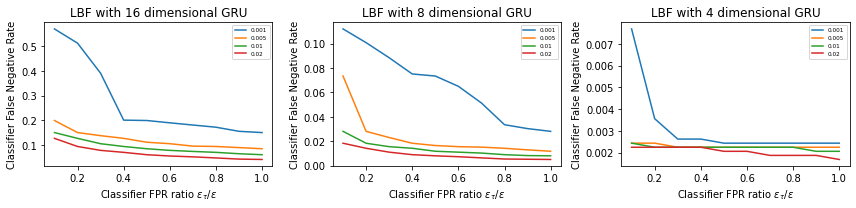

In [49]:
f,ax = plt.subplots(1,3,figsize=(12,3))
for i in range(3):
  fnrs[i].plot(ax=ax[i])
  ax[i].set_xlabel("Classifier FPR ratio "+r"$\epsilon_\tau/\epsilon$")
  ax[i].set_ylabel("Classifier False Negative Rate")
  ax[i].set_title("LBF with "+str(h_sizes[i])+" dimensional GRU")
  ax[i].legend(fontsize='xx-small')
plt.tight_layout()
plt.show()
f.savefig(plot_loc+"LBF_classifier_FNR.png")
# FPR_tau/FPR forced to stay between 0 and 1, 

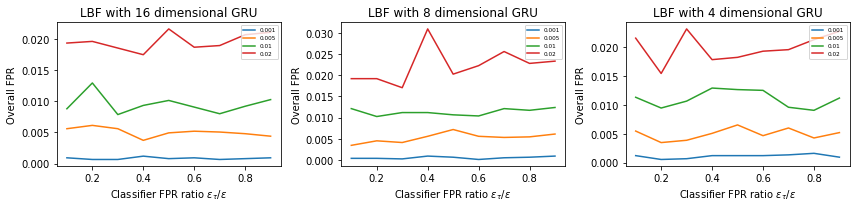

In [50]:
f, ax = plt.subplots(1,3,figsize=(12,3))
for i in range(3):
  true_fpr_LBF[i].plot(ax=ax[i])
  ax[i].set_xlabel("Classifier FPR ratio "+r"$\epsilon_\tau/\epsilon$")
  ax[i].set_ylabel("Overall FPR")
  ax[i].set_title("LBF with "+str(h_sizes[i])+" dimensional GRU")
  ax[i].legend(fontsize='xx-small', loc='upper right')
plt.tight_layout()
plt.show()
f.savefig(plot_loc+"LBF_fpr.png")
#regardless of what the desired FPR is, the curve looks the same??

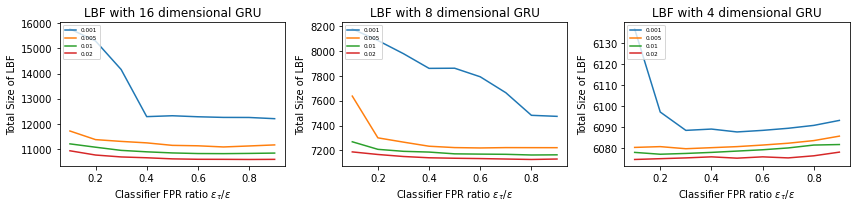

In [51]:
f, ax = plt.subplots(1,3,figsize=(12,3))
for i in range(3):
  sizes_LBF[i].plot(ax=ax[i])
  ax[i].set_xlabel("Classifier FPR ratio "+r"$\epsilon_\tau/\epsilon$")
  ax[i].set_ylabel("Total Size of LBF")
  ax[i].set_title("LBF with "+str(h_sizes[i])+" dimensional GRU")
  ax[i].legend(fontsize='xx-small', loc='upper left')
plt.tight_layout()
plt.show()
f.savefig(plot_loc+"LBF_size.png")
# seems most optimal at 0.5

# $\tau$ analysis for SLBF

In [119]:
fpr_ratios2 = [1.*i for i in range(1,11)]

# Per ognuno dei modelli salvo numero di falsi negativi del classificatore e tau ottimale nelle relative strutture sulla
# base del fprs e fpr_ratio target.
for i in range(3):
  for fpr in fprs:
    for fpr_ratio in fpr_ratios2:
      false_negs[i][(fpr,fpr_ratio)], taus[i][(fpr,fpr_ratio)] = build_LBF_classifier(models[i], fpr*fpr_ratio)
      print("Modello %d: %.3f, %.2f, %.20f, %.10f" % (i, fpr, fpr_ratio, len(false_negs[i][(fpr,fpr_ratio)])/len(phishing_URLs), taus[i][(fpr,fpr_ratio)]))
      # print(len(false_negs[i][(fpr,fpr_ratio)])/len(phishing_URLs), taus[i][(fpr,fpr_ratio)])

Modello 0: 0.001, 1.00, 0.00543682039745031851, 0.8075417292
Modello 0: 0.001, 2.00, 0.00281214848143981986, 0.0485124902
Modello 0: 0.001, 3.00, 0.00262467191601049865, 0.0241809990
Modello 0: 0.001, 4.00, 0.00262467191601049865, 0.0226204381
Modello 0: 0.001, 5.00, 0.00262467191601049865, 0.0223827602
Modello 0: 0.001, 6.00, 0.00262467191601049865, 0.0220769744
Modello 0: 0.001, 7.00, 0.00262467191601049865, 0.0219667040
Modello 0: 0.001, 8.00, 0.00262467191601049865, 0.0218831173
Modello 0: 0.001, 9.00, 0.00243719535058117744, 0.0218052136
Modello 0: 0.001, 10.00, 0.00224971878515185623, 0.0217510585
Modello 0: 0.005, 1.00, 0.00262467191601049865, 0.0223827602
Modello 0: 0.005, 2.00, 0.00224971878515185623, 0.0217510585
Modello 0: 0.005, 3.00, 0.00224971878515185623, 0.0216268881
Modello 0: 0.005, 4.00, 0.00224971878515185623, 0.0215699085
Modello 0: 0.005, 5.00, 0.00224971878515185623, 0.0215214635
Modello 0: 0.005, 6.00, 0.00206224221972253459, 0.0214838182
Modello 0: 0.005, 7.00,

In [120]:
np.save(loc+"false_negs2", false_negs)
np.save(loc+"taus2", taus)

In [121]:
SLBF_initials = {}
SLBF_backups = {}

# Per ognuno dei modelli salvo il filtro di backup e quello iniziale costruito sulla base del fpr e fpr_ratio target
for i in range(3):
  SLBF_initials[i] = {}
  SLBF_backups[i] = {}
  for fpr, fpr_ratio in false_negs[i].keys():
    c=(1.-len(false_negs[i][(fpr,fpr_ratio)])/len(phishing_URLs))
    # Se la tau non rispetta i bound
    if(fpr_ratio < c or fpr*fpr_ratio > c):
      print(fpr_ratio, fpr, "bad fpr_tau")
      continue
    try:
      SLBF_initials[i][(fpr,fpr_ratio)] = build_SLBF_initial(false_negs[i][(fpr,fpr_ratio)], fpr, fpr*fpr_ratio)
      SLBF_backups[i][(fpr,fpr_ratio)] = build_SLBF_backup(false_negs[i][(fpr,fpr_ratio)], fpr*fpr_ratio)
      if(SLBF_backups[i][(fpr,fpr_ratio)] =='error' or SLBF_initials[i][(fpr,fpr_ratio)]=='error'):
        continue
      fpr0, BF_size, t = test_SLBF(SLBF_initials[i][(fpr,fpr_ratio)], models[i], SLBF_backups[i][(fpr,fpr_ratio)], taus[i][(fpr,fpr_ratio)])
      print(fpr, fpr0, BF_size, t)
      SLBF = {"FPR": fpr0, "size": BF_size+model_sizes[i], "time": t}
      np.save(loc+"SLBF_hid"+str(h_sizes[i])+"_FPR"+str(fpr)+"_ratio"+str(fpr_ratio), SLBF)
    except:
      # Eccezione aggiunta per fn =0
      print("Numero di falsi negativi = 0")

# for fpr, fpr_ratio in false_negs2.keys():
#   c=(1.-len(false_negs2[(fpr,fpr_ratio)])/len(phishing_URLs))
#   if(fpr_ratio < c or fpr*fpr_ratio > c):
#     print(fpr_ratio, fpr, "bad fpr_tau")
#     continue
#   SLBF_keys += [(fpr,fpr_ratio)]
#   SLBF_initials[(fpr,fpr_ratio)] = build_SLBF_initial(false_negs2[(fpr,fpr_ratio)], fpr, fpr*fpr_ratio)
#   SLBF_backups[(fpr,fpr_ratio)] = build_SLBF_backup(false_negs2[(fpr,fpr_ratio)], fpr*fpr_ratio)
#   if(SLBF_backups[(fpr,fpr_ratio)] =='error' or SLBF_initials[(fpr,fpr_ratio)]=='error'):
#     continue
#   fpr0, BF_size, t = test_SLBF(SLBF_initials[(fpr,fpr_ratio)], models[2], SLBF_backups[(fpr,fpr_ratio)], taus[(fpr,fpr_ratio)])
#   print(fpr, fpr0, BF_size, t)
#   SLBF = {"FPR": fpr0, "size": BF_size+model_sizes[2], "time": t}
#   np.save(loc+"SLBF_hid"+str(h_sizes[2])+"_FPR"+str(fpr)+"_ratio"+str(fpr_ratio), SLBF)

0.1 0.001 bad fpr_tau
0.2 0.001 bad fpr_tau
0.30000000000000004 0.001 bad fpr_tau
0.4 0.001 bad fpr_tau
0.5 0.001 bad fpr_tau
0.6000000000000001 0.001 bad fpr_tau
0.7000000000000001 0.001 bad fpr_tau
0.8 0.001 bad fpr_tau
0.9 0.001 bad fpr_tau
Numero di falsi negativi = 0
0.1 0.005 bad fpr_tau
0.2 0.005 bad fpr_tau
0.30000000000000004 0.005 bad fpr_tau
0.4 0.005 bad fpr_tau
0.5 0.005 bad fpr_tau
0.6000000000000001 0.005 bad fpr_tau
0.7000000000000001 0.005 bad fpr_tau
0.8 0.005 bad fpr_tau
0.9 0.005 bad fpr_tau
Numero di falsi negativi = 0
0.1 0.01 bad fpr_tau
0.2 0.01 bad fpr_tau
0.30000000000000004 0.01 bad fpr_tau
0.4 0.01 bad fpr_tau
0.5 0.01 bad fpr_tau
0.6000000000000001 0.01 bad fpr_tau
0.7000000000000001 0.01 bad fpr_tau
0.8 0.01 bad fpr_tau
0.9 0.01 bad fpr_tau
Numero di falsi negativi = 0
0.1 0.02 bad fpr_tau
0.2 0.02 bad fpr_tau
0.30000000000000004 0.02 bad fpr_tau
0.4 0.02 bad fpr_tau
0.5 0.02 bad fpr_tau
0.6000000000000001 0.02 bad fpr_tau
0.7000000000000001 0.02 bad fpr_t

In [122]:
fnrs2 = {}
# Per ognuno dei modelli costruisco un dataframe in cui salvo il rate di falsi negativi per ogni fpr e fprs_ratio
for i in range(3):
  fnrs2[i] = pd.DataFrame(index=fpr_ratios+fpr_ratios2, columns=fprs)
  for fpr,fpr_ratio in false_negs[i].keys():
      fnrs2[i].loc[fpr_ratio,fpr] = len(false_negs[i][(fpr,fpr_ratio)])/len(phishing_URLs)
  # for fpr,fpr_ratio in false_negs2.keys():
      # fnrs2[i].loc[fpr_ratio,fpr] = len(false_negs2[i][(fpr,fpr_ratio)])/len(phishing_URLs)

In [134]:
true_fpr_SLBF = {}
sizes_SLBF = {}
times_SLBF = {}

# Per ogni modello salvo in base a fpr, fpr_ratio target l'frp empirico, la grandezza ed il tempo di accesso per elemento
# del SLBF relativo
# Utile per i grafici successivi
for i in range(3):
  true_fpr_SLBF[i] = pd.DataFrame(index = fpr_ratios+fpr_ratios2, columns = fprs)
  sizes_SLBF[i] = pd.DataFrame(index = fpr_ratios+fpr_ratios2, columns = fprs)
  times_SLBF[i] = pd.DataFrame(index = fpr_ratios+fpr_ratios2, columns = fprs)
  for fpr,fpr_ratio in false_negs[i].keys():
    try:
      SLBF = np.load(loc+"SLBF_hid"+str(h_sizes[i])+"_FPR"+str(fpr)+"_ratio"+str(fpr_ratio)+".npy", allow_pickle=True).item()
      true_fpr_SLBF[i].loc[fpr_ratio,fpr] = SLBF['FPR']
      sizes_SLBF[i].loc[fpr_ratio,fpr] = SLBF['size']
      times_SLBF[i].loc[fpr_ratio,fpr] = SLBF['time']
      print(SLBF['FPR'], SLBF['size'], SLBF['time'])
    except:
      print("error", fpr_ratio, fpr) # Bad tau + false negs = 0
      continue

# for fpr,fpr_ratio in false_negs2.keys():
#   try:
#     SLBF = np.load(loc+"SLBF_hid"+str(h_sizes[2])+"_FPR"+str(fpr)+"_ratio"+str(fpr_ratio)+".npy").item()
#     true_fpr_SLBF.loc[fpr_ratio,fpr] = SLBF['FPR']
#     sizes_SLBF.loc[fpr_ratio,fpr] = SLBF['size']
#     times_SLBF.loc[fpr_ratio,fpr] = SLBF['time']
#     print(SLBF['FPR'], SLBF['size'], SLBF['time'])
#   except:
#     print("error")
#     continue

error 0.1 0.001
error 0.2 0.001
error 0.30000000000000004 0.001
error 0.4 0.001
error 0.5 0.001
error 0.6000000000000001 0.001
error 0.7000000000000001 0.001
error 0.8 0.001
error 0.9 0.001
error 1.0 0.001
error 0.1 0.005
error 0.2 0.005
error 0.30000000000000004 0.005
error 0.4 0.005
error 0.5 0.005
error 0.6000000000000001 0.005
error 0.7000000000000001 0.005
error 0.8 0.005
error 0.9 0.005
error 1.0 0.005
error 0.1 0.01
error 0.2 0.01
error 0.30000000000000004 0.01
error 0.4 0.01
error 0.5 0.01
error 0.6000000000000001 0.01
error 0.7000000000000001 0.01
error 0.8 0.01
error 0.9 0.01
error 1.0 0.01
error 0.1 0.02
error 0.2 0.02
error 0.30000000000000004 0.02
error 0.4 0.02
error 0.5 0.02
error 0.6000000000000001 0.02
error 0.7000000000000001 0.02
error 0.8 0.02
error 0.9 0.02
error 1.0 0.02
error 2.0 0.001
error 3.0 0.001
error 4.0 0.001
error 5.0 0.001
error 6.0 0.001
error 7.0 0.001
error 8.0 0.001
error 9.0 0.001
error 10.0 0.001
error 2.0 0.005
error 3.0 0.005
error 4.0 0.005
err

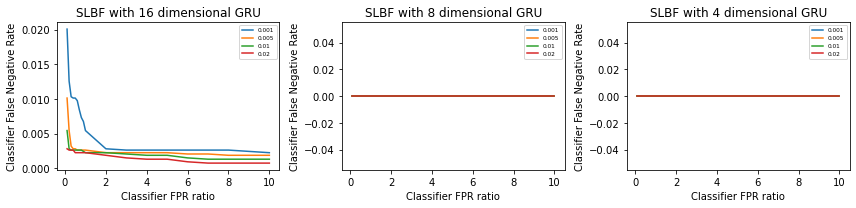

In [124]:
f,ax = plt.subplots(1,3,figsize=(12,3))
for i in range(3):
  fnrs2[i].plot(ax=ax[i])
  ax[i].legend(fontsize='xx-small')
  ax[i].set_xlabel("Classifier FPR ratio")
  ax[i].set_ylabel("Classifier False Negative Rate")
  ax[i].set_title("SLBF with "+str(h_sizes[i])+" dimensional GRU")
plt.tight_layout()
plt.show()
f.savefig(plot_loc+"SLBF_classifier_FNR.png")

# FPR_tau/FPR forced to stay between 0 and 1, 

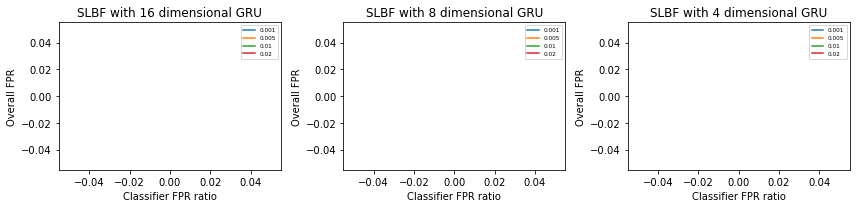

In [135]:
f,ax=plt.subplots(1,3,figsize=(12,3))
for i in range(3):
  true_fpr_SLBF[i].plot(ax=ax[i])
  ax[i].legend(fontsize='xx-small')
  ax[i].set_xlabel("Classifier FPR ratio")
  ax[i].set_ylabel("Overall FPR")
  ax[i].set_title("SLBF with "+str(h_sizes[i])+" dimensional GRU")
plt.tight_layout()
plt.show()
f.savefig(plot_loc+"SLBF_fpr.png")


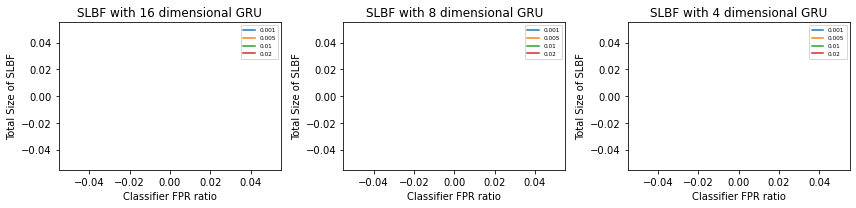

In [126]:
f, ax = plt.subplots(1,3,figsize=(12,3))
for i in range(3):
  sizes_SLBF[i].plot(ax=ax[i])
  ax[i].legend(fontsize='xx-small')
  ax[i].set_xlabel("Classifier FPR ratio")
  ax[i].set_ylabel("Total Size of SLBF")
  ax[i].set_title("SLBF with "+str(h_sizes[i])+" dimensional GRU")
plt.tight_layout()
plt.show()
f.savefig(plot_loc+"SLBF_size.png")


#size is best when ratio = 1

In [127]:
true_fpr_LBF_LH = {}
sizes_LBF_LH = {}
times_LBF_LH = {}
for i in range(3):
  true_fpr_LBF_LH[i] = pd.DataFrame(index = fpr_ratios, columns = fprs)
  sizes_LBF_LH[i] = pd.DataFrame(index = fpr_ratios, columns = fprs)
  times_LBF_LH[i] = pd.DataFrame(index = fpr_ratios, columns = fprs)
  for fpr in fprs:
    for fpr_ratio in fpr_ratios:
      try:
        LBF = np.load(loc+"LBF_LH_hid"+str(h_sizes[i])+"_FPR"+str(fpr)+"_ratio"+str(fpr_ratio)+".npy", allow_pickle=True).item()
        true_fpr_LBF_LH[i].loc[fpr_ratio,fpr] = LBF['FPR']
        sizes_LBF_LH[i].loc[fpr_ratio,fpr] = LBF['size']
        times_LBF_LH[i].loc[fpr_ratio,fpr] = LBF['time']
        print(LBF['FPR'], LBF['size'], LBF['time'])
      except:
        print("error")
        continue


error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error


In [ ]:
# Grafici attualmente non funzionanti, da sistemare

x_BF = []
y_BF = []
for b in BF_sizes.keys():
  x_BF += [b]
  y_BF += [BF_sizes[b]]

In [ ]:
f,ax = plt.subplots(1,3,figsize=(12,3))
for i in range(3):
  x_LBF = []
  y_LBF = []
  z_LBF = []
  x_SLBF = []
  y_SLBF = []
  z_SLBF = []
  for j1 in range(true_fpr_LBF[i].shape[1]):
    for j0 in range(true_fpr_LBF[i].shape[0]):
      x_LBF += [true_fpr_LBF[i].iloc[j0,j1]]
      y_LBF += [sizes_LBF[i].iloc[j0,j1]]
    z_LBF += [min(sizes_LBF[i].iloc[:,j1])]
  
  for j1 in range(true_fpr_SLBF[i].shape[1]):
    for j0 in range(true_fpr_SLBF[i].shape[0]):
      if sizes_SLBF[i].dropna().iloc[:,j1].size != 0:
        if(true_fpr_SLBF[i].index[j0] >= 1.):
          x_SLBF += [true_fpr_SLBF[i].iloc[j0,j1]]
          y_SLBF += [sizes_SLBF[i].iloc[j0,j1]]
        z_SLBF += [min(sizes_SLBF[i].dropna().iloc[:,j1])]
        
  ax[i].scatter(x_LBF,y_LBF, label = 'LBF', marker='.')
  ax[i].scatter(x_SLBF,y_SLBF, label = 'SLBF', marker='.')
  ax[i].plot(true_fpr_LBF[i].columns,z_LBF)
  ax[i].plot(true_fpr_SLBF[i].columns,z_SLBF)
  ax[i].set_title(str(h_sizes[i])+" dimensional GRU")
  ax[i].set_xlabel("Observed FPR")
  ax[i].set_ylabel("Total Size (bytes)")
  ax[i].set_xlim(left=0, right=0.03)
  ax[i].legend(fontsize='xx-small')
plt.tight_layout()
plt.show()
f.savefig(plot_loc+"comparison_size_min.png")